In [1]:
from pathlib import Path
import sys
scripts_dir = Path("/hetghome/antonpr/xmax_sigma/flincpy/scripts_01")
sys.path.insert(0, str(scripts_dir/"mceq_2d"))

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from mceq2d_dists import MCEQDist2D, CalcMCEqHists
from scipy.interpolate import interp1d

In [3]:
mceq_sol = MCEQDist2D(
                 energy = 100,
                 pdg_id = 2212,
                 theta_deg = 30,
                 slant_depths = [143, 647, 1033],
                 energy_range = [1e-1, 1e4],
                 interaction_model = "EPOS-LHC", 
                 hybrid_crossover = 0.1,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): EPOSLHC
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


100%|██████████| 2559/2559 [00:21<00:00, 119.10it/s]


In [17]:
res0 = mceq_sol.mceq_run.convert_to_theta_space(
                mceq_sol.mceq_run.grid_sol, 13, 0)

In [186]:

import mceq_config as config
import scipy
def convert_to_theta_space(
    self,
    hankel_transf,
    pdg_id,
    hel,
    oversample_res=5,
    theta_res=600,
    log_theta=False,
):
    """Converts the Hankel space amplitudes from the 2D MCEq solver
    to the real (angular) space. 

    Args:
        hankel_transf (list of np.arrays): list of Hankel space solutions at the requested slant depths
        (i.e. the output of self.grid_sol)
        pdg_id (int): PDG ID of the particle whose angular density is being requested (e.g. 14 for NuMu)
        hel (int): helicity of the particle whose angular density is being requested (e.g. 0 or ±1 for polarized muons)
        oversample_res (int): resolution of the Hankel grid oversampling (used to approximate the continuous inverse Hankel transform)
        theta_res (int): resolution of the angular (theta) grid where the inverse Hankel transform will output the densities
        log_theta (bool): whether to return logarithmic angular grid (True=logarithmic, False=linear)

    """
    if log_theta:
        theta_range = np.logspace(-5, np.log10(np.pi / 2), theta_res)
    else:
        theta_range = np.linspace(0, np.pi / 2, theta_res)
    # oversample_pts = np.max(config.k_grid) * oversample_res
    # oversample_pts = len(config.k_grid) * oversample_res
    # oversampled_k_arr = np.linspace(
    #     np.min(config.k_grid), np.max(config.k_grid), oversample_pts
    # )
    
    oversample_pts = len(config.k_grid)
    oversampled_k_arr = config.k_grid
    j0_ktheta_k = (
        scipy.special.j0(np.outer(oversampled_k_arr, theta_range))
        * oversampled_k_arr[:, None]
    )

    store_oversampled_hankel_amps = [
        [[] for eidx in range(len(self.e_grid))] for j in range(len(hankel_transf))
    ]
    store_inverse_hankel_transfs = [
        [[] for eidx in range(len(self.e_grid))] for j in range(len(hankel_transf))
    ]

    for j in range(len(hankel_transf)):

        for eidx in range(len(self.e_grid)):

            mceqidx = self.pman.pdg2mceqidx[(pdg_id, hel)] * len(self.e_grid) + eidx
            # oversampled_hankel_amps = interp1d(
            #     config.k_grid, hankel_transf[j][:, mceqidx]#, kind="cubic"
            # )(oversampled_k_arr)
            
            oversampled_hankel_amps = hankel_transf[j][:, mceqidx]
            inverse_hankel_transf = np.trapz(
                j0_ktheta_k * oversampled_hankel_amps[:, None],
                oversampled_k_arr,
                axis=0,
            )

            store_oversampled_hankel_amps[j][eidx] = oversampled_hankel_amps
            store_inverse_hankel_transfs[j][eidx] = inverse_hankel_transf

    return (
        oversampled_k_arr,
        store_oversampled_hankel_amps,
        theta_range,
        store_inverse_hankel_transfs,
    )

In [ ]:
import mceq_config as config
import scipy
def convert_to_theta_space11(
    self,
    hankel_transf,
    pdg_id,
    hel,
    oversample_res=5,
    theta_res=600,
    log_theta=False,
):
    """Converts the Hankel space amplitudes from the 2D MCEq solver
    to the real (angular) space. 

    Args:
        hankel_transf (list of np.arrays): list of Hankel space solutions at the requested slant depths
        (i.e. the output of self.grid_sol)
        pdg_id (int): PDG ID of the particle whose angular density is being requested (e.g. 14 for NuMu)
        hel (int): helicity of the particle whose angular density is being requested (e.g. 0 or ±1 for polarized muons)
        oversample_res (int): resolution of the Hankel grid oversampling (used to approximate the continuous inverse Hankel transform)
        theta_res (int): resolution of the angular (theta) grid where the inverse Hankel transform will output the densities
        log_theta (bool): whether to return logarithmic angular grid (True=logarithmic, False=linear)

    """
        
    if log_theta:
        theta_range = np.logspace(-5, np.log10(np.pi / 2), theta_res)
    else:
        theta_range = np.linspace(0, np.pi / 2, theta_res)
    oversample_pts = np.max(config.k_grid) * oversample_res
    oversampled_k_arr = np.linspace(
        np.min(config.k_grid), np.max(config.k_grid), oversample_pts
    )
    j0_ktheta_k = (
        scipy.special.j0(np.outer(oversampled_k_arr, theta_range))
        * oversampled_k_arr[:, None]
    )

    store_oversampled_hankel_amps = [
        [[] for eidx in range(len(self.e_grid))] for j in range(len(hankel_transf))
    ]
    store_inverse_hankel_transfs = [
        [[] for eidx in range(len(self.e_grid))] for j in range(len(hankel_transf))
    ]

    for j in range(len(hankel_transf)):

        for eidx in range(len(self.e_grid)):

            mceqidx = self.pman.pdg2mceqidx[(pdg_id, hel)] * len(self.e_grid) + eidx
            oversampled_hankel_amps = interp1d(
                config.k_grid, hankel_transf[j][:, mceqidx], kind="cubic"
            )(oversampled_k_arr)
            inverse_hankel_transf = np.trapz(
                j0_ktheta_k * oversampled_hankel_amps[:, None],
                oversampled_k_arr,
                axis=0,
            )

            store_oversampled_hankel_amps[j][eidx] = oversampled_hankel_amps
            store_inverse_hankel_transfs[j][eidx] = inverse_hankel_transf

    return (
        oversampled_k_arr,
        store_oversampled_hankel_amps,
        theta_range,
        store_inverse_hankel_transfs,
    )

In [6]:
ihaha = mceq_sol.mceq_run.grid_sol

In [5]:
mceq_sol.mceq_run.grid_sol.shape

(3, 24, 1071)

In [696]:
ihaha.shape

(24, 1071)

In [125]:
def convert_to_theta_space_pyhank(
    self,
    hankel_transf,
    pgd_hels,
    theta_grid = None
):
    """Converts the Hankel space amplitudes from the 2D MCEq solver
    to the real (angular) space. 

    Args:
        hankel_transf (list of np.arrays): list of Hankel space solutions at the requested slant depths
        (i.e. the output of self.grid_sol)
        pdg_id (int): PDG ID of the particle whose angular density is being requested (e.g. 14 for NuMu)
        hel (int): helicity of the particle whose angular density is being requested (e.g. 0 or ±1 for polarized muons)
        oversample_res (int): resolution of the Hankel grid oversampling (used to approximate the continuous inverse Hankel transform)
        theta_res (int): resolution of the angular (theta) grid where the inverse Hankel transform will output the densities
        log_theta (bool): whether to return logarithmic angular grid (True=logarithmic, False=linear)

    """
    
    from pyhank import HankelTransform
    import time 
    
    oversampled_k_grid = np.linspace(np.min(config.k_grid), np.max(config.k_grid), 1024)
    st1 = time.time()
    ht_obj = HankelTransform(order=0, k_grid = oversampled_k_grid)
    st2 = time.time()
    print(st2 - st1)
    
    
    len_egrid = len(self.e_grid)
    en_inds = []
    for pgd_hel in pgd_hels:
        start_ind =  self.pman.pdg2mceqidx[pgd_hel] * len_egrid
        end_ind = start_ind + len_egrid
        en_inds.append(np.arange(start_ind, end_ind))

    en_slice = np.concatenate(en_inds)
    hankel_transf_red = hankel_transf[:,:,en_slice]
        
    oversampled_hankel_amps = interp1d(config.k_grid, hankel_transf_red, axis = 1, kind = "cubic")(ht_obj.kr)
    
    inverse_hankel_transfs = ht_obj.iqdht(oversampled_hankel_amps, axis = 1)*(2*np.pi)
    
    if theta_grid is None:
        theta_grid = ht_obj.r
        angular_space = inverse_hankel_transfs
    else:
        angular_space = interp1d(ht_obj.r, inverse_hankel_transfs, axis = 1,
                                        fill_value="extrapolate")(theta_grid)
    
    st3 = time.time()
    print(st3 - st2)
    
    
    start_ind = 0
    angular_space_part = []
    for i in enumerate(pgd_hels):
        end_ind = start_ind + len_egrid
        angular_space_part.append(angular_space[:,:, start_ind:end_ind])
        start_ind = end_ind
    
    return (oversampled_k_grid, 
            oversampled_hankel_amps,
            theta_grid, 
            angular_space_part
            )
        


In [91]:
res_org = mceq_sol.mceq_run.convert_to_theta_space(
                mceq_sol.mceq_run.grid_sol, 13, 0, theta_res = 91)

In [142]:
res_py = convert_to_theta_space_pyhank(
    mceq_sol.mceq_run,
    mceq_sol.mceq_run.grid_sol,
    [(13, 0), (13, 1), (13, -1), (12, 0), (14, 0)],
    theta_grid = res_org[2]
)

0.6925053596496582
0.04112672805786133


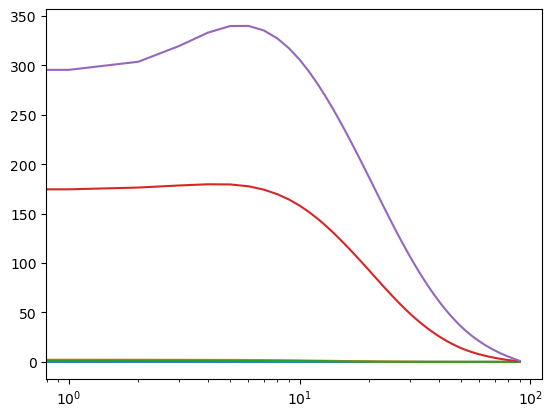

In [145]:
plt.plot(np.rad2deg(res_py[2]), res_py[3][0][2,:,0])
plt.plot(np.rad2deg(res_py[2]), res_py[3][1][2,:,0])
plt.plot(np.rad2deg(res_py[2]), res_py[3][2][2,:,0])
plt.plot(np.rad2deg(res_py[2]), res_py[3][3][2,:,0])
plt.plot(np.rad2deg(res_py[2]), res_py[3][4][2,:,0])

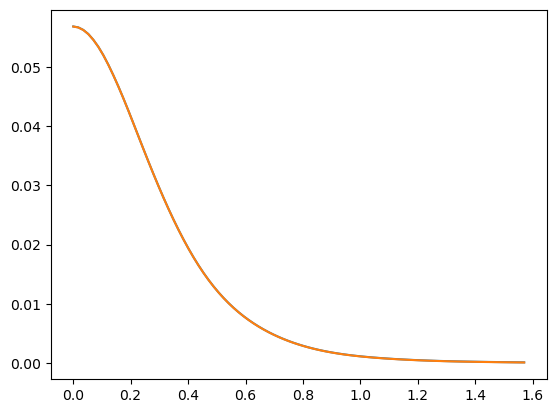

In [97]:
plt.plot(res_py[2], res_py[3][0,:,4])
plt.plot(res_org[2], res_org[3][0][4][:])

In [98]:
pdg2mceqidx = mceq_sol.mceq_run.pman.pdg2mceqidx

In [99]:
pdg2mceqidx[(13, 0)]

6

In [106]:
pdg2mceqidx = mceq_sol.mceq_run.pman.pdg2mceqidx
e_grid = mceq_sol.mceq_run.e_grid

pgd_hels = [(13, 0), (13, 1), (13, -1), (12, 0), (14, 0)]

len_egrid = len(e_grid)
en_inds = []
for pgd_hel in pgd_hels:
    start_ind = pdg2mceqidx[pgd_hel] * len_egrid
    end_ind = start_ind + len_egrid
    en_inds.append(np.arange(start_ind, end_ind))
        

print(np.concatenate(en_inds))

start_ind = 0
for pgd_hel in pgd_hels:
    end_ind = start_ind + len_egrid
    print(np.concatenate(en_inds)[start_ind:end_ind])
    start_ind = end_ind
    
    # en_inds = np.array([en_inds])

[306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488
 489 490 491 492 493 494 495 496 497 498 499 500 50

In [12]:
import time
import mceq_config as config

In [8]:
from pyhank import HankelTransform

In [17]:
theata_grid = np.deg2rad(np.linspace(0, 90, 1024))

In [40]:
k_grid = np.linspace(0, 2000, 2000)

In [41]:
HT = HankelTransform(order=0, k_grid = k_grid)

In [42]:
ErH = interp1d(config.k_grid, ihaha, axis = 1)(HT.kr)

In [43]:
start = time.time()
EkrH = HT.iqdht(ErH, axis = 1)
end = time.time()
print(end - start)

0.3234705924987793


(0.0, 1.6)

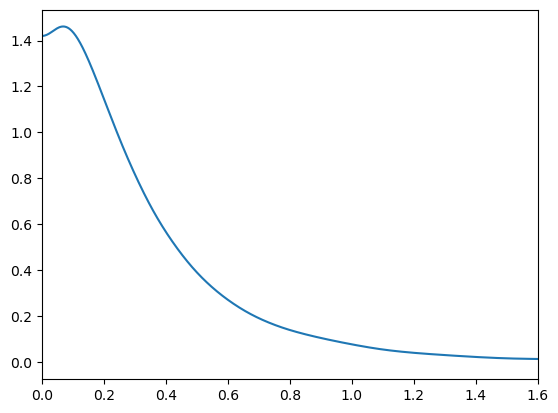

In [44]:
plt.plot(HT.r, (EkrH[0,:,0])/(2*np.pi))
plt.xlim(0, 1.6)

In [598]:
oversampled_k_arr = np.linspace(0, 2000, 10000)

In [599]:
j0_ktheta_k = (
    scipy.special.j0(np.outer(oversampled_k_arr, theata_grid))
    * oversampled_k_arr[:, None]
)

In [709]:
oversampled_hankel_amps = interp1d(
                config.k_grid,  mceq_sol.mceq_run.grid_sol[0], axis = 0
            )(oversampled_k_arr)


In [722]:
start = time.time()
inverse_hankel_transf = np.trapz(
                j0_ktheta_k[:, :, None] * oversampled_hankel_amps[:, None],
                oversampled_k_arr,
                axis=0,
            )
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [723]:
j0_ktheta_k[:, None] * oversampled_hankel_amps[:, :,None]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

       [[ 1.52605049e+00,  1.52605039e+00,  1.52605008e+00, ...,
          1.48886849e+00,  1.48874479e+00,  1.48862090e+00],
        [ 1.36918553e+00,  1.36918543e+00,  1.36918515e+00, ...,
          1.33582551e+00,  1.33571453e

In [602]:
hhh = HT.to_original_k(EkrH)/(2*np.pi)

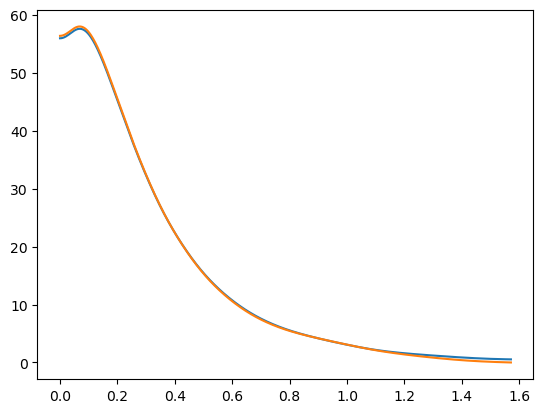

In [603]:
plt.plot(theata_grid, inverse_hankel_transf)
plt.plot(theata_grid, hhh)

In [610]:
hhh[0:5]

array([56.34696808, 56.35258133, 56.36915158, 56.39636645, 56.4339121 ])

In [612]:
inverse_hankel_transf[0:5]

array([55.92509222, 55.93079938, 55.94743404, 55.97481381, 56.01258313])

(0.0, 100.0)

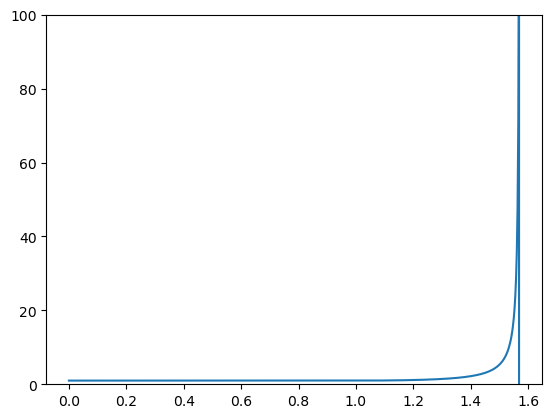

In [609]:
plt.plot(theata_grid, inverse_hankel_transf/hhh)
plt.ylim(0, 100)

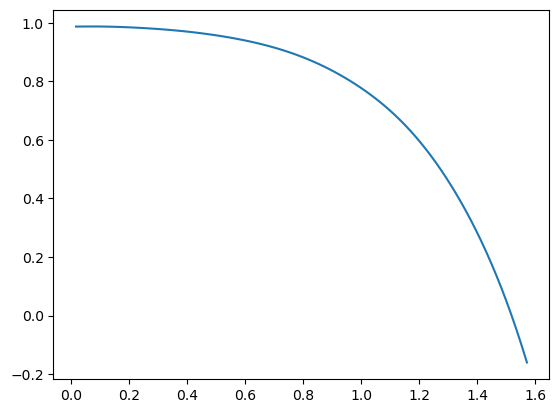

In [475]:
plt.plot(theata_grid[1:], inverse_hankel_transf[1:]/hhh)
# plt.plot(HT.kr, EkrH)

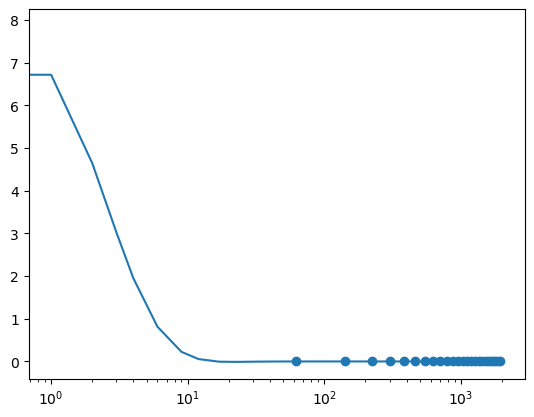

In [375]:
plt.scatter(HT.kr, ErH)
plt.plot(config.k_grid, mceq_sol.mceq_run.grid_sol[0].T[0])
plt.xscale("log")

In [345]:
config.k_grid

array([   0,    1,    2,    3,    4,    6,    9,   12,   17,   23,   32,
         44,   61,   84,  115,  158,  217,  299,  410,  563,  773, 1061,
       1457, 2000])

In [225]:
res11 = convert_to_theta_space(mceq_sol.mceq_run,
                mceq_sol.mceq_run.grid_sol, 13, 0,
                oversample_res=1,
                theta_res=91)

In [222]:
res1 = mceq_sol.mceq_run.convert_to_theta_space(
                mceq_sol.mceq_run.grid_sol, 13, 0,
                oversample_res=5,
                theta_res=91)

In [232]:
config.k_grid

array([   0,    1,    2,    3,    4,    6,    9,   12,   17,   23,   32,
         44,   61,   84,  115,  158,  217,  299,  410,  563,  773, 1061,
       1457, 2000])

In [236]:
np.geomspace(1, 2000, 23)

array([1.00000000e+00, 1.41268983e+00, 1.99569255e+00, 2.81929456e+00,
       3.98278875e+00, 5.62644516e+00, 7.94842184e+00, 1.12286547e+01,
       1.58626062e+01, 2.24089425e+01, 3.16568851e+01, 4.47213595e+01,
       6.31774097e+01, 8.92500841e+01, 1.26082686e+02, 1.78115728e+02,
       2.51622277e+02, 3.55464231e+02, 5.02160703e+02, 7.09397317e+02,
       1.00215837e+03, 1.41573894e+03, 2.00000000e+03])

In [351]:
mceq_sol.mceq_run.grid_sol[0].T[0]

array([ 7.85837035e+00,  6.71408027e+00,  4.64231650e+00,  3.02771962e+00,
        1.94693664e+00,  8.13618485e-01,  2.24690604e-01,  5.55117028e-02,
       -6.04170024e-03, -1.00454100e-02, -4.51821439e-03, -1.13020857e-03,
       -1.17971962e-04,  4.30773553e-06,  1.40003809e-06, -1.42734850e-08,
       -1.65004264e-08, -6.30338862e-09,  1.07775562e-09, -1.15649321e-09,
       -7.36926770e-11,  2.84124775e-11, -1.17982394e-10,  2.55356992e-11])

In [263]:
xintp = np.geomspace(1, 2000, 32)
intp = interp1d(config.k_grid, mceq_sol.mceq_run.grid_sol[0].T[0]
            )(xintp)


In [265]:
mceq_sol.mceq_run.grid_sol[0].T[0]

array([ 7.85837035e+00,  6.71408027e+00,  4.64231650e+00,  3.02771962e+00,
        1.94693664e+00,  8.13618485e-01,  2.24690604e-01,  5.55117028e-02,
       -6.04170024e-03, -1.00454100e-02, -4.51821439e-03, -1.13020857e-03,
       -1.17971962e-04,  4.30773553e-06,  1.40003809e-06, -1.42734850e-08,
       -1.65004264e-08, -6.30338862e-09,  1.07775562e-09, -1.15649321e-09,
       -7.36926770e-11,  2.84124775e-11, -1.17982394e-10,  2.55356992e-11])

In [266]:
config.k_grid

array([   0,    1,    2,    3,    4,    6,    9,   12,   17,   23,   32,
         44,   61,   84,  115,  158,  217,  299,  410,  563,  773, 1061,
       1457, 2000])

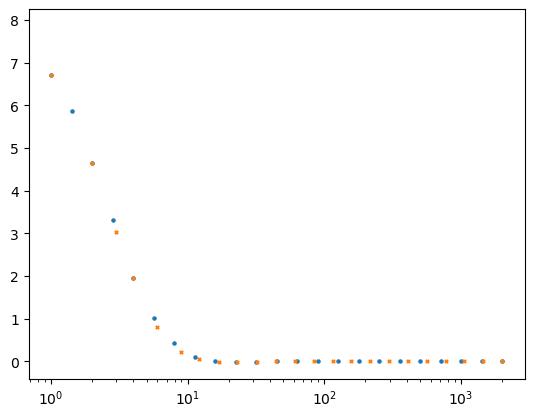

In [249]:
plt.scatter(np.geomspace(1, 2000, 23), intp, s = 5)
plt.scatter(config.k_grid, mceq_sol.mceq_run.grid_sol[0].T[0], s = 5, marker = "x")
plt.xscale("log")

In [255]:
henk_array = mceq_sol.mceq_run.grid_sol[0].T[0]

In [259]:
len(henk_array)

24

In [276]:
np.logspace(-1, np.log10(2000), 21)

array([1.00000000e-01, 1.64078433e-01, 2.69217322e-01, 4.41727563e-01,
       7.24779664e-01, 1.18920712e+00, 1.95123240e+00, 3.20155155e+00,
       5.25305561e+00, 8.61913133e+00, 1.41421356e+01, 2.32041945e+01,
       3.80730788e+01, 6.24697111e+01, 1.02499323e+02, 1.68179283e+02,
       2.75945932e+02, 4.52767762e+02, 7.42894249e+02, 1.21892924e+03,
       2.00000000e+03])

In [330]:
import scipy.fft as fft
# from  scipy.fft import fht

mu = 0.0                     # Order mu of Bessel function
rxx = np.logspace(-7, np.log10(2000*(1 - 1e-10)), 128)
dln = np.log(rxx[1]/rxx[0])      # Step size
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)

# r = np.logspace(-7, 1, 128)  # Input evaluation points
# dln = np.log(r[1]/r[0])      # Step size
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)
ktheta = np.exp(offset)/rxx[::-1]   # Output evaluation points

intp = interp1d(config.k_grid[:], mceq_sol.mceq_run.grid_sol[0].T[0][:]*(config.k_grid[:])**2
            )(rxx)
# xintp = np.geomspace(1, 2000, 32)
# intp
ress = fft.fht(intp, dln, mu = mu, bias = -1)

In [ ]:
j0_ktheta_k = (
            scipy.special.j0(np.outer(oversampled_k_arr, theta_range))
            * oversampled_k_arr[:, None]
        )

(1e-07, 2924.7011471139235)

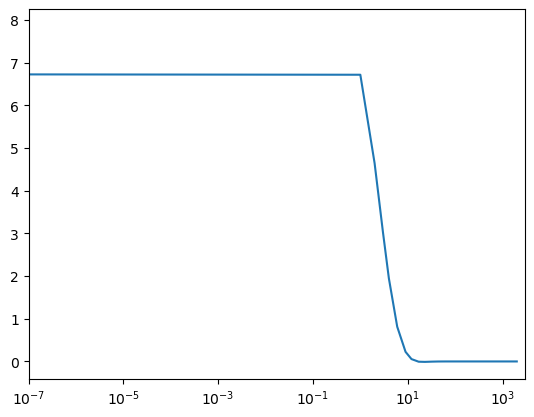

In [344]:
plt.plot(config.k_grid, mceq_sol.mceq_run.grid_sol[0].T[0])
plt.xscale("log")
plt.xlim(1e-7)

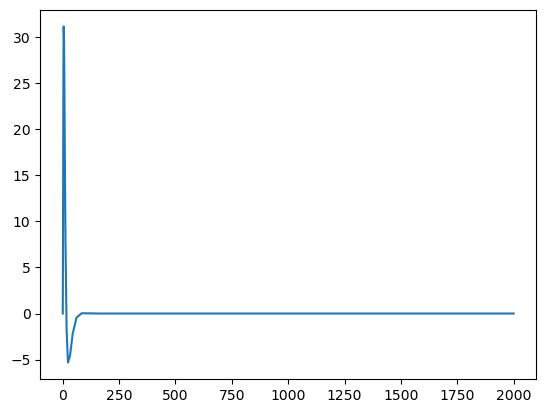

In [341]:
plt.plot(config.k_grid[:], mceq_sol.mceq_run.grid_sol[0].T[0][:]*(config.k_grid[:])**2)

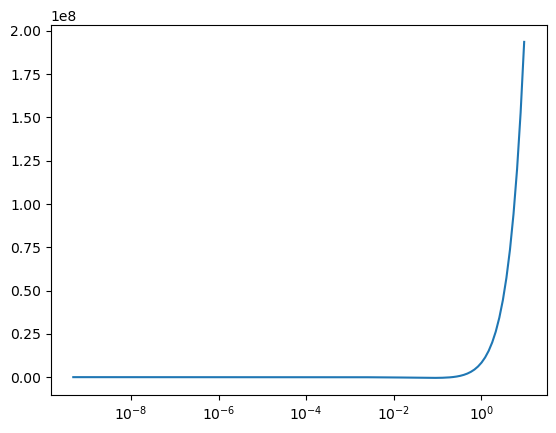

In [331]:
plt.plot(ktheta, ress)
plt.xscale("log")

In [302]:
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)

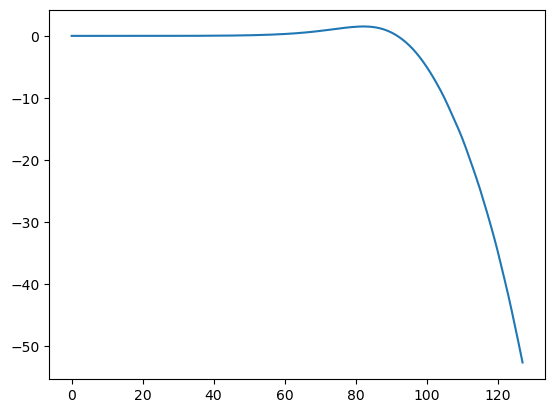

In [305]:
plt.plot(ress)

In [231]:
mceq_sol.mceq_run.grid_sol[0].T[0]

array([ 7.85837035e+00,  6.71408027e+00,  4.64231650e+00,  3.02771962e+00,
        1.94693664e+00,  8.13618485e-01,  2.24690604e-01,  5.55117028e-02,
       -6.04170024e-03, -1.00454100e-02, -4.51821439e-03, -1.13020857e-03,
       -1.17971962e-04,  4.30773553e-06,  1.40003809e-06, -1.42734850e-08,
       -1.65004264e-08, -6.30338862e-09,  1.07775562e-09, -1.15649321e-09,
       -7.36926770e-11,  2.84124775e-11, -1.17982394e-10,  2.55356992e-11])

24

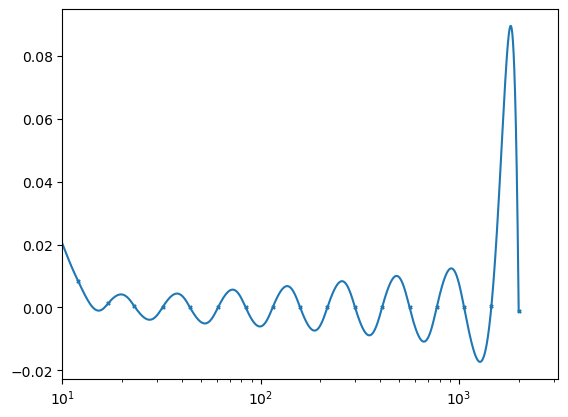

In [224]:
ien = 1
# plt.scatter(res0[0], res0[1][0][ien], s=5, marker = ".")
# plt.scatter(res1[0], res1[1][0][ien], s=5, marker = "x")
res_plt = res1
plt.plot(res_plt[0], res_plt[1][0][ien]*res_plt[0]**3)
plt.scatter(res11[0], res11[1][0][ien]*res11[0]**3, s=5, marker = "x")
plt.xscale("log")
plt.xlim(10)
# plt.ylim(-1e-7, 1e-7)
# plt.yscale("log")
len(res11[0])

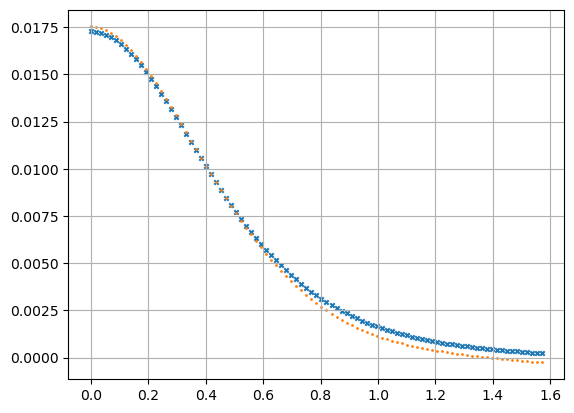

In [317]:
ien = 0
# res1_intp = interp1d(res1[2], res1[3][0][ien])(res0[2])
# res1[3][0][ien][res1[3][0][ien] < 0] = 0
# res0[3][0][ien][res0[3][0][ien] < 0] = 0
plt.scatter(res1[2], res1[3][0][ien], s=10, marker = "x")
plt.scatter(res11[2], res11[3][0][ien], s=1, marker = "o")
# plt.xlim(1, 1.2)
# plt.ylim(1, 1.2)
plt.grid()

In [142]:
mceq_sol.mceq_run.grid_sol[:][0]

array([[ 7.85837035e+00,  7.02799567e+00,  5.89297091e+00, ...,
        -1.35849269e-42,  1.42034346e-44, -1.34402560e-46],
       [ 6.71408027e+00,  6.11432390e+00,  5.24657153e+00, ...,
        -1.35849262e-42,  1.42034339e-44, -1.34402554e-46],
       [ 4.64231650e+00,  4.41319165e+00,  3.98291200e+00, ...,
        -1.35849240e-42,  1.42034319e-44, -1.34402536e-46],
       ...,
       [ 2.84124775e-11, -2.97726266e-10,  7.75954314e-10, ...,
        -1.31776046e-42,  1.38309925e-44, -1.31145776e-46],
       [-1.17982394e-10,  5.31148174e-10,  2.82698169e-10, ...,
        -1.30013297e-42,  1.36771339e-44, -1.29866833e-46],
       [ 2.55356992e-11, -3.66106181e-10,  2.00125691e-10, ...,
        -1.27667265e-42,  1.34801986e-44, -1.28298714e-46]])

In [88]:
res0 = mceq_sol.mceq_run.convert_to_theta_space(
                mceq_sol.mceq_run.grid_sol, 13, 0)

In [109]:
res1 = mceq_sol.mceq_run.convert_to_theta_space(
                mceq_sol.mceq_run.grid_sol, 13, 0,
                oversample_res=5,
                theta_res=20)

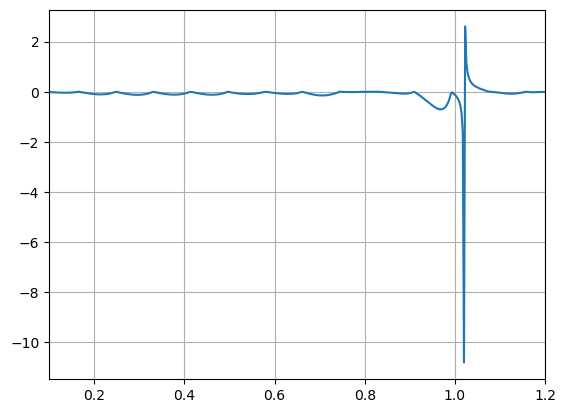

In [102]:
ien = 10
res1_intp = interp1d(res1[2], res1[3][0][ien])(res0[2])
# plt.plot(res1[2], res1[3][0][ien])
plt.plot(res0[2], 1-(res1_intp/res0[3][0][ien]))
plt.xlim(0.1, 1.2)
plt.grid()

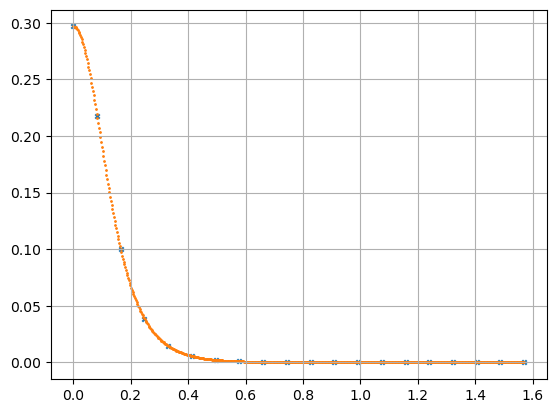

In [112]:
ien = 10
res1_intp = interp1d(res1[2], res1[3][0][ien])(res0[2])
res1[3][0][ien][res1[3][0][ien] < 0] = 0
res0[3][0][ien][res0[3][0][ien] < 0] = 0
plt.scatter(res1[2], res1[3][0][ien], s=10, marker = "x")
plt.scatter(res0[2], res0[3][0][ien], s=1, marker = "o")
# plt.xlim(1, 1.2)
# plt.ylim(1, 1.2)
plt.grid()

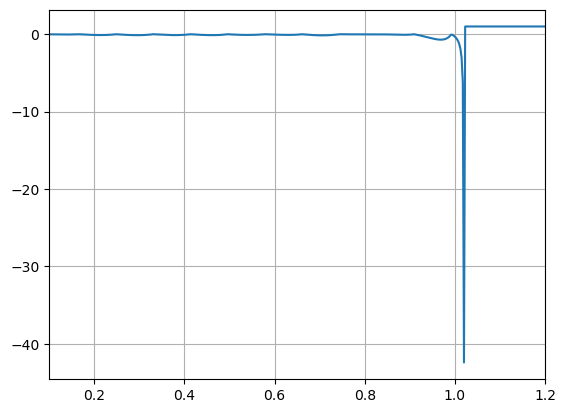

In [115]:
ien = 10
res1_intp = interp1d(res1[2], res1[3][0][ien])(res0[2])
# plt.plot(res1[2], res1[3][0][ien])
plt.plot(res0[2], 1-np.divide(res1_intp,res0[3][0][ien], where = res0[3][0][ien] > 0))
plt.xlim(0.1, 1.2)
plt.grid()

In [110]:
arr = res1[3][0][ien]
arr[arr < 0] = 0
arr

array([2.96808808e-01, 2.17659682e-01, 9.98934214e-02, 3.86178446e-02,
       1.46568223e-02, 5.73416971e-03, 2.25696701e-03, 1.00084101e-03,
       3.91135980e-04, 1.78389663e-04, 1.00047257e-04, 2.82837038e-05,
       2.47547470e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [105]:
res0[3][0][ien]

array([ 2.96808808e-01,  2.96660433e-01,  2.96375407e-01,  2.95919372e-01,
        2.95237762e-01,  2.94396639e-01,  2.93356792e-01,  2.92122667e-01,
        2.90723279e-01,  2.89158324e-01,  2.87414694e-01,  2.85488142e-01,
        2.83387233e-01,  2.81124992e-01,  2.78712762e-01,  2.76157412e-01,
        2.73461786e-01,  2.70627579e-01,  2.67656957e-01,  2.64553480e-01,
        2.61322773e-01,  2.57972514e-01,  2.54511539e-01,  2.50949091e-01,
        2.47294454e-01,  2.43556637e-01,  2.39744167e-01,  2.35864931e-01,
        2.31926176e-01,  2.27934692e-01,  2.23897029e-01,  2.19819578e-01,
        2.15708607e-01,  2.11570332e-01,  2.07410959e-01,  2.03236710e-01,
        1.99053829e-01,  1.94868575e-01,  1.90687182e-01,  1.86515782e-01,
        1.82360324e-01,  1.78226499e-01,  1.74119712e-01,  1.70045059e-01,
        1.66007297e-01,  1.62010830e-01,  1.58059702e-01,  1.54157588e-01,
        1.50307782e-01,  1.46513187e-01,  1.42776316e-01,  1.39099317e-01,
        1.35483995e-01,  

In [ ]:
pdg_id,
        hel,
        oversample_res=5,
        theta_res=600,
        log_theta=False,

In [118]:
import numpy as np
from scipy.integrate import quadrature

# Define the function to be integrated
def func(x):
    return np.sin(x)

# Define the lower and upper bounds of integration
a, b = 0, np.pi

# Choose the degree of the Gaussian quadrature rule
n = 3

# Perform Gaussian quadrature and output evaluation points
result, eval_pts = quadrature(func, a, b, rtol=1e-12, maxiter=100, vec_func=True, show=True)

# Print the result and the evaluation points
print("Result:", result)
print("Evaluation points:", eval_pts)

TypeError: quadrature() got an unexpected keyword argument 'show'